#Analysis of Accidents in North American Mountineering
Analysis and visual summary of accident data collected in [Accidents in North American Mountaineering](https://www.americanalpineclub.org/p/anam) (ANAM) from 1951 to 2014. ANAM is published annualy by the [American Alpine Club](https://www.americanalpineclub.org/). The data is included here in three Excel spreadsheets. Have fun and come up with your own analysis!

###Dependencies:
```
Python 3
```
Python libraries:
```
math
pandas
matplotlib
numpy
shapefile
shapely
squarify
windrose
```

###Load Libraries
Load python libraries for plotting (matplotlib), data analysis (numpy, pandas), mapping (Basemap) and spatial manipulation (shapefile, shapely)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
%run pretty_breaks.py

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon as plt_poly
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from mpl_toolkits.basemap import Basemap
import shapefile

from shapely.geometry import Polygon as Shp_poly
from shapely.ops import unary_union

###Data Munge
Import the spreadsheet data into a pandas dataframe, extract the relavent columns and label them
Aggregate the data across all years 1951-2014
Join two regions to form a more sensible group


In [2]:
#load data and reshape into Pandas dataframe
tb2 = pd.ExcelFile('ANAM_1951-2014_byregion.xlsx')
tb2 = tb2.parse('Sheet1')
can_thru2013 = tb2[['Unnamed: 0','Unnamed: 1','Unnamed: 2','Unnamed: 3']].loc[4:12]
usa_thru2013 = tb2[['Unnamed: 0','Unnamed: 1','Unnamed: 2','Unnamed: 3']].loc[15:26]
can_2014 = tb2[['Unnamed: 0','Unnamed: 4','Unnamed: 5','Unnamed: 6']].loc[4:12]
usa_2014 = tb2[['Unnamed: 0','Unnamed: 4','Unnamed: 5','Unnamed: 6']].loc[15:26]
can_thru2013.columns = ['region','accidents','deaths','persons']
usa_thru2013.columns = ['region','accidents','deaths','persons']
can_2014.columns = ['region','accidents','deaths','persons']
usa_2014.columns = ['region','accidents','deaths','persons']
states = [['Alaska'],
          ['Arizona','Nevada','Texas'],
          ['Indiana','Ohio','Maine','New Hampshire','Vermont','Massachusetts','New York','Pennsylvania','Rhode Island','Connecticut','New Jersey','Delaware','Maryland'],
          ['Virginia','South Carolina','North Carolina','Kentucky','Georgia','Florida','West Virginia','Tennessee','Alabama'],
          ['California'],
          ['Minnesota','South Dakota','Michigan','Wisconsin','North Dakota','Iowa','Illinois','Kansas','Nebraska','Missouri','Oklahoma','Mississippi','Arkansas','Louisiana'],
          ['Colorado'],
          ['Montana','Idaho'],
          ['Oregon'],
          ['Utah','New Mexico'],
          ['Washington'],
          ['Wyoming']]
usa_thru2013['states'] = states
usa_2014['states'] = states

provinces = [['Alberta'],['British Columbia'],['Yukon'],['New Brunswick'],['Ontario'],['Québec'],['Nunavut','Newfoundland and Labrador','Nova Scotia'],['Northwest Territories'],['practice']]
can_thru2013['states'] = provinces
can_2014['states'] = provinces

thru2013 = pd.concat([usa_thru2013,can_thru2013])
thru2013 = thru2013.convert_objects(convert_numeric=True) #convert 'n/a' string to python NaN
year_2014 = pd.concat([usa_2014,can_2014])
year_2014 = year_2014.convert_objects(convert_numeric=True)

allDates = thru2013.copy()
allDates['accidents'] = thru2013.accidents + year_2014.accidents.fillna(0)
allDates['deaths'] = thru2013.deaths + year_2014.deaths.fillna(0)
allDates['persons'] = thru2013.persons + year_2014.persons.fillna(0)

#join AZ,NV, TX with UT, NM
allDatesJoin = allDates.copy()
allDatesJoin.iloc[1] = allDatesJoin.iloc[1] + allDatesJoin.iloc[9]
allDatesJoin = allDatesJoin.drop(allDatesJoin.index[[9]])


###Draw a chloropleth map 
Color indicates the number of accidents in each geographic region

[]

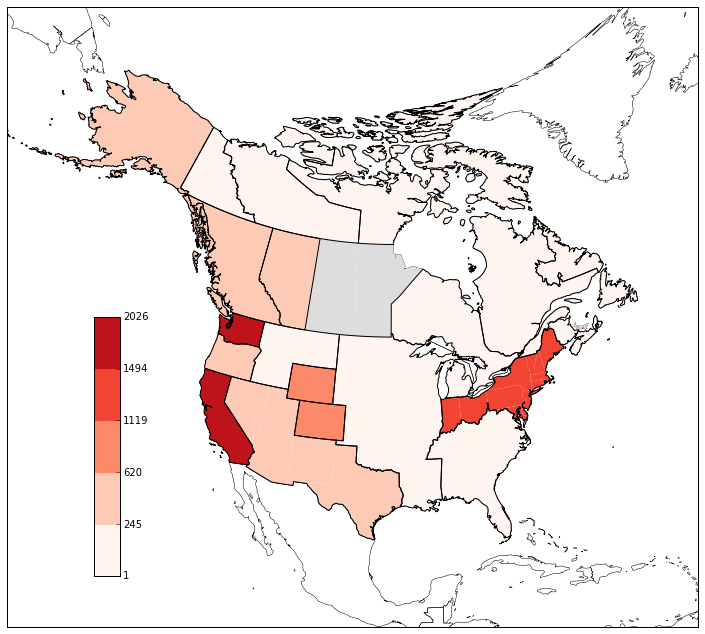

In [3]:

map = Basemap(llcrnrlon=-135,llcrnrlat=5,urcrnrlon=-5,urcrnrlat=70,projection='aea',lat_1=33,lat_2=45,lon_0=-95)
        
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

map.readshapefile('./countries/ne_50m_admin_0_countries', 'countries', drawbounds = True)
map.readshapefile('./states/ne_50m_admin_1_states_provinces_lakes', 'states', drawbounds = False)

cm = plt.get_cmap('Reds')
num_colors = 5
scheme = [cm(i / num_colors) for i in range(num_colors)]

df = allDatesJoin #which data to map
values = df.accidents.astype('float64').values
#bins = np.linspace(values.min(), values.max(), num_colors).round() #for linearly spaced bins
bins = jenks(values,num_colors) #use jenks binning algorithm, note: jenks sorts the values list
bins[num_colors] = bins[num_colors]+1
df['bin'] = np.digitize(df.accidents.astype('float64').values, bins)


#draw colored patches
patches   = []
colors = []
for info, shape in zip(map.states_info, map.states):
    color = '#dddddd'
    for idx,states in enumerate(df['states'].values):
        if  info['name'] in states:
            color = scheme[df.iloc[idx]['bin']-1]

    patches = [plt_poly(np.array(shape), True)]
    pc = PatchCollection(patches , edgecolor='none', alpha = 1.0, linewidths=1., zorder=2)
    pc.set_facecolor(color)
    ax.add_collection(pc)
    
#draw borders around regions    
for idx,states in enumerate(df['states'].values):
    polygons = []
    for info, shape in zip(map.states_info, map.states):
        if  info['name'] in states:
            polygons.append(Shp_poly(np.array(shape)))
    
    try:
        borders = polygons[0]
        for poly in polygons[1:]:
            borders = borders.union(poly)
    except IndexError:
        borders = polygons
    
    try:
        for border in borders:
            patches = [plt_poly(np.array(border.exterior), True)]
            bc = PatchCollection(patches , edgecolor='k', facecolor='none', alpha = 1.0, linewidths=1., zorder=3)
            ax.add_collection(bc)
    except TypeError:
        patches = [plt_poly(np.array(borders.exterior), True)]
        bc = PatchCollection(patches , edgecolor='k', facecolor='none', alpha = 1.0, linewidths=1., zorder=3)
        ax.add_collection(bc)

# Draw color legend.
ax_legend = fig.add_axes([0.2, 0.2, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=None, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(i) for i in bins])


###Save Map figure to pdf

In [4]:
fig.savefig('map_allDatesJoin_accidents_thru2014.pdf',dpi=150,orientation='landscape',transparent=True, format='pdf')

###Create Treemap
Create a treemap visualization of the different causes of accidents. Import `squarify` library. Accident causes are in "ANAM_1951-2014_bytype.xlsx" and were manually transcribed into variables `sub` and `obj` for subjective and objective causes.

(0, 1000)

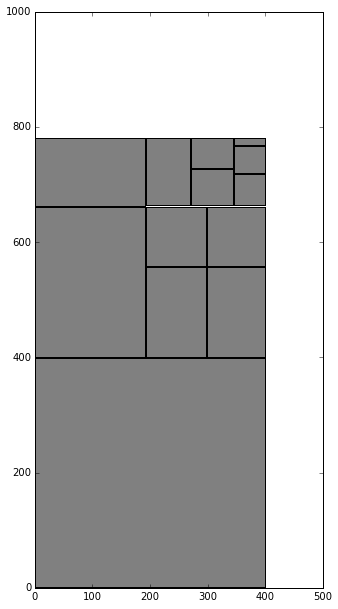

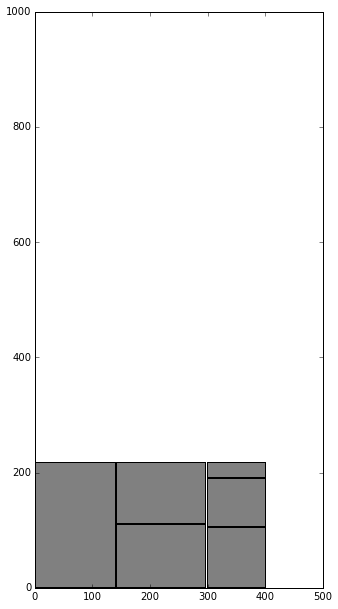

In [5]:
import squarify as sq

sub = [4340,1365,626,452,435,249,302,290,131,108,74,84,20] 
obj = [832,477,455,296,240,75]
sub.sort(reverse=True)
obj.sort(reverse=True)
width = 400
height = 1000

sub_height = height*sum(sub)/(sum(sub)+sum(obj))
obj_height = height*sum(obj)/(sum(sub)+sum(obj))

sub[:] = [x / sum(sub) *width*sub_height for x in sub]
obj[:] = [x / sum(obj) *width*obj_height for x in obj]

sub_rects = sq.padded_squarify(sub, 0, 0, width, sub_height)
obj_rects = sq.padded_squarify(obj, 0, 0, width, obj_height)

#Plot subjective cause treemap
fig2 = plt.figure(figsize=(5,10))
ax = fig2.add_axes([0.1,0.1,0.8,0.8])

for rect in sub_rects:
    box = [ [rect['x'],rect['y']], [rect['x']+rect['dx'],rect['y']], [rect['x']+rect['dx'],rect['y']+rect['dy']], [rect['x'],rect['y']+rect['dy']] ]
    patch = plt_poly(np.array(box), closed=True, edgecolor = 'k', facecolor='gray')
    ax.add_patch(patch)

ax.set_xlim(0,500)
ax.set_ylim(0,1000)

#Plot objective cause treemap
fig3 = plt.figure(figsize=(5,10))
ax = fig3.add_axes([0.1,0.1,0.8,0.8])

for rect in obj_rects:
    box = [ [rect['x'],rect['y']], [rect['x']+rect['dx'],rect['y']], [rect['x']+rect['dx'],rect['y']+rect['dy']], [rect['x'],rect['y']+rect['dy']] ]
    patch = plt_poly(np.array(box), closed=True, edgecolor = 'k', facecolor='gray')
    ax.add_patch(patch)

ax.set_xlim(0,500)
ax.set_ylim(0,1000)

###Save figures to pdf

In [6]:
fig2.savefig('subjective_dangers_treemap_thru2014.pdf',dpi=150,orientation='portrait',transparent=True, format='pdf')
fig3.savefig('objective_dangers_treemap_thru2014.pdf',dpi=150,orientation='portrait',transparent=True, format='pdf')

###Plot Windrose
Create windrose visualization of the number of accidents in each month of the year.

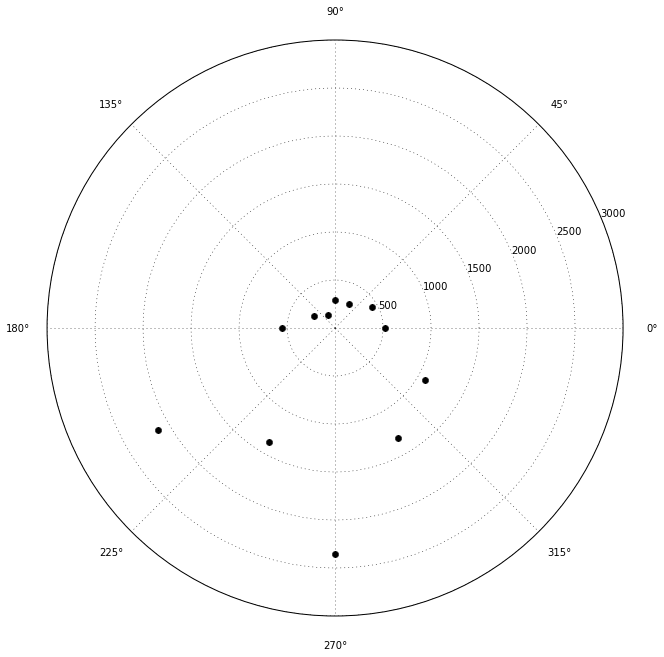

In [7]:
from windrose import WindroseAxes

accidents_per_month = [290,291,444,520,1086,1319,2355,1367,2129,556,257,153] #total accidents in each month
month_angle = 360/12
month = [(120-(i*month_angle))*np.pi/180 for i in [1,2,3,4,5,6,7,8,9,10,11,12]] 

fig4 = plt.figure(figsize=(10,10))
ax = fig4.add_axes([0.1,0.1,0.8,0.8],projection='polar')

ax.plot(month, accidents_per_month,'ok', linewidth=3)
ax.set_rmax(3000.0)
ax.grid(True)

###Save figures to pdf

In [8]:
fig4.savefig('months_rose_thru2014.pdf',dpi=150,orientation='landscape',transparent=True, format='pdf')